In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json
import os
from scipy import stats
import pandas as pd
import datetime
from probssm.ivp import sir_rhs

We wish to observe the marginal effect of the ODE covariance on the fit results, heuristically. We want to develop intuition about the impact of the ODE covariance on the state estimates. We plot the results for the states to diagnose the marginal effect.

In [2]:
def beta_link_fn(x, info, data, y_offset=0.0, exp=True):
    slope = info["sigmoid_slope"]
    x_offset = -scipy.special.logit(data["beta_prior_mean"])
    if exp:
        return np.exp(x)
    else:
        return scipy.special.expit(slope * (x - x_offset)) + y_offset
    
def prop_std(state_idx, step):
    return np.exp(arr["means"][::step, state_idx]) * np.sqrt(arr["covs"][::step, state_idx, state_idx])

## Plotting results

Data Covariance : 5e-09
Diffusion intensity (beta) : 0.005
Diffusion intensity (x) : 0.005
Step Size of ODE filter : 0.16667
ODE parameters : gamma = 0.04517, eta = 0.00549


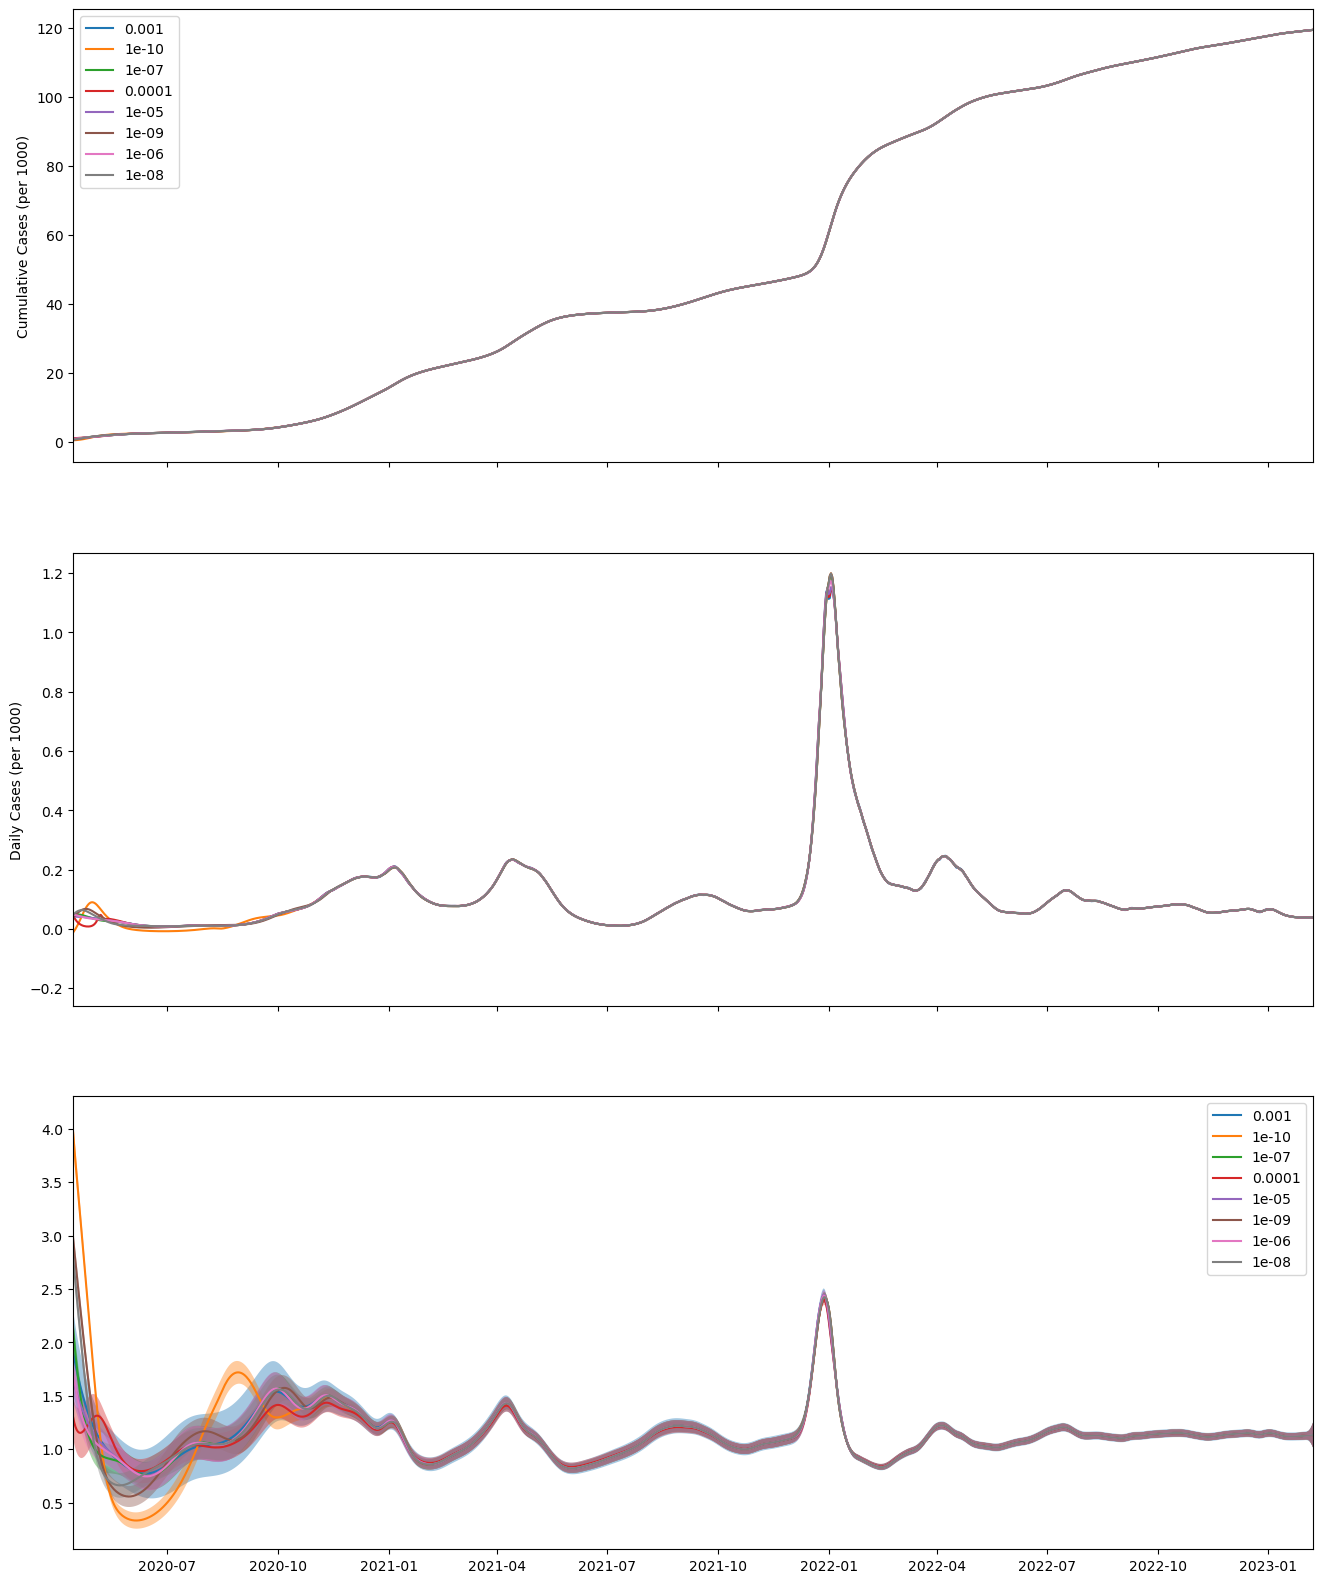

In [17]:
fig,axs = plt.subplots(3, 1, figsize=(16,20), sharex=True)

for run in [el for el in os.listdir() if el.startswith("run_can")]:
    arr = np.load(run + "/posterior_first.npz")
    data = np.load(run + "/data_info.npz")
    
    if data["ode_measurement_cov"] >= 1e-2 or data["ode_measurement_cov"] <=1e-11: #plotting condition
        continue
        
    if data["ode_measurement_cov"] in [5e-8, 5e-7]:
        continue
        
    with open(run + "/info.json") as f:
        info = json.load(f)
        
    tmin_idx, tmax_idx = data["time_domain"].astype(int)
    dates = data["date_range_x"][tmin_idx : tmax_idx]

    N = 1000.0
    skip_first_n_days = 90

    step = 1+int(1/info["filter_step_size"])

    obs = pd.DataFrame({"daily": np.abs(np.diff(data["sir_data"][:, 0], prepend=data["sir_data"].max())),
                  "cum" : N - data["sir_data"][:,0]},
                  index = dates) 
    
    
    #(log_S)' = (1/S) S'(t) -> S'(t) = S(t) * (log_S)'. Daily case count is -S'(t). Cum cases is N - S(t)
    predicted_daily_cases = - (np.exp(arr["means"][:, 0]) * arr["means"][:,1])[::step] 
    predicted_cum_cases = N - np.exp(arr["means"][:, 0])[::step]

    # sigma_S = sigma_logS * d/dS (f(S)) = sigma_logS * exp(S)
    pred_cum_err = 3 * (np.sqrt(arr["covs"][:, 0,0]) * np.exp(arr["means"][:, 0]))[::25]

    r_t_high = (beta_link_fn(arr["means"][:,-2][::step], info, data) + 3*prop_std(-2, step))/data["gamma"]
    r_t_low = (beta_link_fn(arr["means"][:,-2][::step], info, data) - 3*prop_std(-2, step))/data["gamma"]
    r_t_mid = beta_link_fn(arr["means"][:,-2][::step], info, data)/data["gamma"]

    #axs[0].plot(obs.index, obs.cum, '.', color='orange', alpha=0.5, label="Observations")
    axs[0].plot(obs.index, predicted_cum_cases, label=data["ode_measurement_cov"])
    #axs[0].fill_between(obs.index, predicted_cum_cases - pred_cum_err, predicted_cum_cases + pred_cum_err)

    #axs[1].plot(obs.index, obs.daily, '.', color='orange', alpha=0.5)
    axs[1].plot(obs.index, predicted_daily_cases)

    axs[2].fill_between(obs.index[skip_first_n_days:], r_t_low[skip_first_n_days:], r_t_high[skip_first_n_days:], alpha = 0.4)
    axs[2].plot(obs.index[skip_first_n_days:], r_t_mid[skip_first_n_days:], label=data["ode_measurement_cov"])


    
axs[2].legend() 
axs[0].legend()
axs[1].set_ylabel("Daily Cases (per 1000)")
axs[0].set_ylabel("Cumulative Cases (per 1000)")
axs[0].set_xlim(dates[skip_first_n_days], dates[-1]);

print("Data Covariance : {}".format(data["data_measurement_cov"]))
print("Diffusion intensity (beta) : {}".format(data["beta_process_diffusion"]))
print("Diffusion intensity (x) : {}".format(data["x_process_diffusion"]))
print("Step Size of ODE filter : {:.5f}".format(info["filter_step_size"]))
print("ODE parameters : gamma = {:.5f}, eta = {:.5f}".format(data["gamma"], data["eta"]))

Conclusion: The choice of ODE covariance does not affect the results past a time stamp around 2021-01. Prior to that time stamp, the estimate (mean) and uncertainty (standard deviation) are both affected by the choice of ODE covariance. In particular, the uncertainty in state estimates increases with increasing ODE covariance. Moreover, the regime covariance<1e-10 displays strange behaviors, as it moves out of the 3$\sigma$ range of other cases where covariance>1e-10.